In [66]:
from train import basic_transforms, mean, std # TODO: Move to utils?
from render_shape import ShapeRenderer
from utils import unnormalize_functional, rgba_to_rgb, unnormalize_to
from models import Model
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from IPython.display import SVG, display
import svgwrite
from cairosvg import svg2png
from pathlib import Path
from tqdm.notebook import tqdm
import io

In [2]:
n_shapes = 16
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(n_shapes=n_shapes).to(device)
renderer = ShapeRenderer(device=device, imsize=image_size, minimum_sharpness=10).to(device)

model.load_state_dict(torch.load(r".\checkpoints\celeba.pt")['G'])
model.to(device)
model.eval()
pass

'Input image'

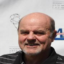

'Fuzzy training output'

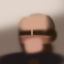

'Crisp evaluation output'

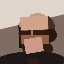

In [16]:
# Load image and view it
input_image = Image.open(r"C:\projects\data\celeba_val\main\008189.jpg")
input_tensor = basic_transforms(input_image).to(device)
display("Input image", TF.to_pil_image(unnormalize_functional(input_tensor, mean, std)))

# Forward image through net and renderer
shape_args = model(input_tensor.unsqueeze(0))
renderer.train()
output_image = rgba_to_rgb(renderer(shape_args).squeeze(0))
display("Fuzzy training output", TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

# Render using sharp images
renderer.eval()
output_image = rgba_to_rgb(renderer(shape_args).squeeze(0))
display("Crisp evaluation output", TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

# Only process the shape colors etc., don't render
output_image_args = renderer(shape_args, return_mode="shapes").squeeze(0).detach().cpu()

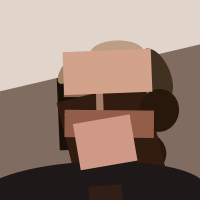

In [87]:
svg_string = get_svg(output_image_args, canvas_size=200)
display(SVG(svg_string))

In [91]:
input_path = Path(r"G:\Simon\Pictures\zimonitrome\zimo avatars")
canvas_size = 200
output_path = Path("./highres_outputs/") / (input_path.parent.name + "_pred")
output_path.mkdir(exist_ok=True, parents=True)

files = list(input_path.iterdir())
model.eval()
renderer.eval()

for file in tqdm(files):
    # I/O paths
    png_path = output_path / (file.stem + ".png")
    svg_path = output_path / (file.stem + ".svg")

    # Prepare image
    input_image = Image.open(file).convert("RGB")
    input_tensor = basic_transforms(input_image).to(device)

    # Run image through model
    shape_args = model(input_tensor.unsqueeze(0))
    output_image_args = renderer(shape_args, return_mode="shapes").squeeze(0).detach().cpu()
    svg_string = get_svg(output_image_args, canvas_size=canvas_size)
    
    # Save SVG
    with open(svg_path, "w") as svg_file:
        svg_file.write(svg_string)

    # Save SVG as PNG and remove SVG
    with open(svg_path, mode="rb") as svg_file:
        svg2png(bytestring=svg_file.read(), write_to=str(png_path))
    svg_path.unlink()

  0%|          | 0/10 [00:00<?, ?it/s]